# RME analysis

Plot of the peak SWE on March 14, 2006.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import h5py
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_context('paper')

In [2]:
# Read in the model results
nc = h5py.File('../output/rme/devel/wy2006/rme_longterm_2006/runs/run0000_8759/snow.nc', 'r')
# swe = nc['specific_mass'][165,:] # March 14, 2006 as an index
swe = nc['specific_mass'][190,:] # March 14, 2006 as an index
x = nc['x'][:]
y = nc['y'][:]
dates = pd.to_datetime('2005-10-01 00:00:00') + pd.to_timedelta(nc['time'][:], unit='h')

mask_file = h5py.File('topo/topo.nc')
mask = mask_file['mask'][:]
mask_file.close()

In [3]:
# Read in the pillow site data
meas_swe = pd.read_csv('station_data/RME_pillow_site.csv', parse_dates=True, index_col='date_time')

# measurement location, UTM 11
meas_location_x = 519970
meas_location_y = 4768100

# find the index in the model results
ind_x = np.argmin(np.abs(meas_location_x - x))
ind_y = np.argmin(np.abs(meas_location_y - y))

# meas_location_y
val = pd.DataFrame(index=dates)
val.index.name = 'date_time'
val['model_swe'] = nc['specific_mass'][:, ind_y, ind_x]
val['model_zs'] = nc['thickness'][:, ind_y, ind_x] * 100 # meters to cm
nc.close()

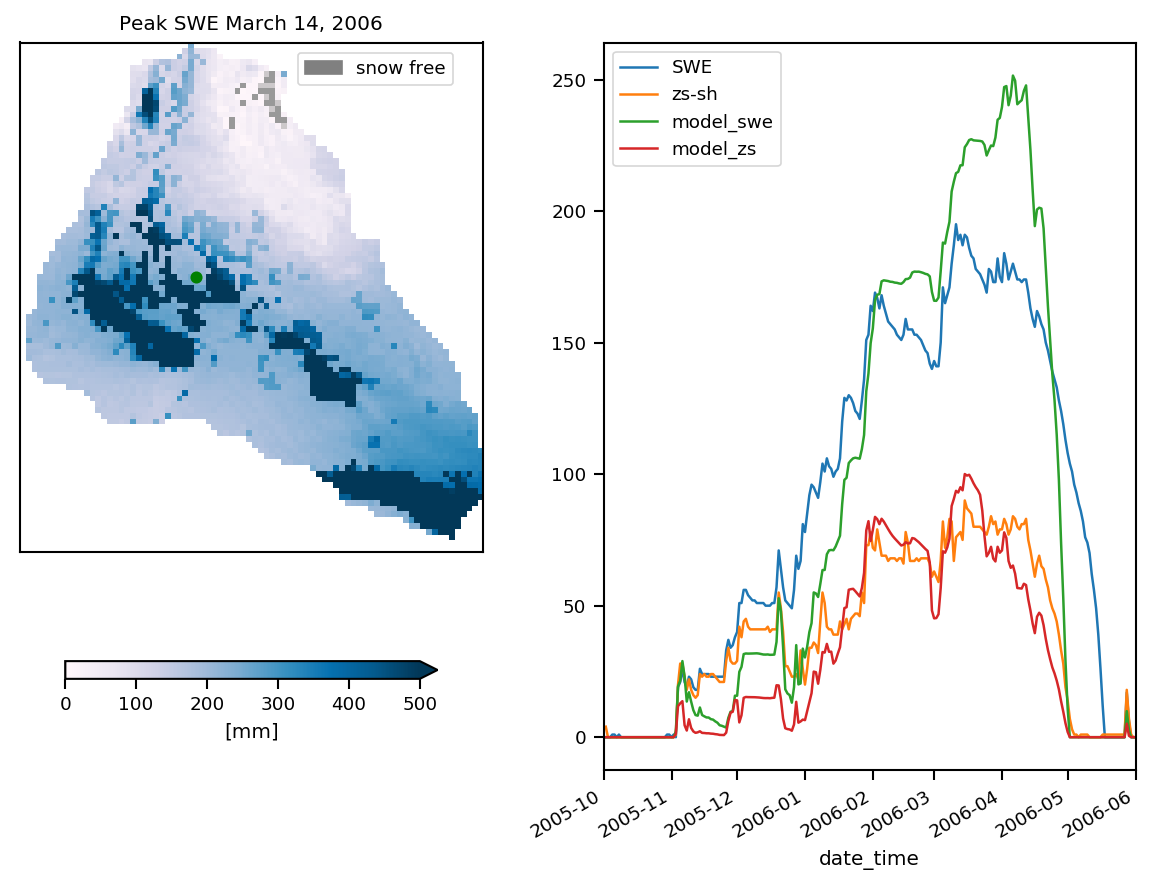

In [4]:
# mask RME
swe[mask == 0] = np.nan

# create the colormap
colorsbad = plt.cm.Set1_r(np.linspace(0., 1, 1))
colors1 = plt.cm.PuBu(np.linspace(0, 1, 128))

colors = np.vstack((colorsbad, colors1))
cmap = mcolors.LinearSegmentedColormap.from_list('swe_colormap', colors)
cmap.set_bad('white',1.)

# Plot the figure
fig, (ax1, ax2) = plt.subplots(figsize=(8, 6), dpi=150, nrows = 1, ncols = 2)

# RCEW basin SWE image
vmin = 0
vmax = 500
s = ax1.imshow(swe, vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
s.axes.get_xaxis().set_ticks([])
s.axes.get_yaxis().set_ticks([])
ax1.set_title('Peak SWE March 14, 2006')
ax1.plot(ind_x, ind_y, 'go')

# Add the colorbar
cbar = fig.colorbar(s, ax=ax1, extend='max', shrink=0.7, orientation='horizontal')
cbar.set_label('[mm]')

p = [patches.Patch(color='grey', label='snow free')]
ax1.legend(handles=p, bbox_to_anchor=(0.6, 0.98),
          loc=2, borderaxespad=0.)

# plot the pillow and the model
df = pd.concat([meas_swe, val], axis=1)
df.dropna(how='any', axis=0, inplace=True)
# df.drop(df[df.index > '2006-06-01'].index, inplace=True)
df.plot(ax=ax2)
ax2.set_xlim('2005-10-01', '2006-06-01')
# ax2.set_ylim(0, 200)


plt.tight_layout()
# plt.savefig('rme_figure.png', dpi=200)